In [1]:
%matplotlib notebook

In [2]:
import numpy as np
import xtrack as xt
import matplotlib.pyplot as plt

### Reload the line

In [3]:
line = xt.Line.from_json('pimms_00_optics.json')
line.build_tracker()

Loading line from dict:   0%|          | 0/221 [00:00<?, ?it/s]

Done loading line from dict.           
Found suitable prebuilt kernel `default_only_xtrack`.


### Activate extraction sextupoles

In [4]:
line.vars['kse1'] = 1
line.vars['kse2'] = -6.5

### Analysis from the previous notebook moved intoa function:

<IPython.core.display.Javascript object>


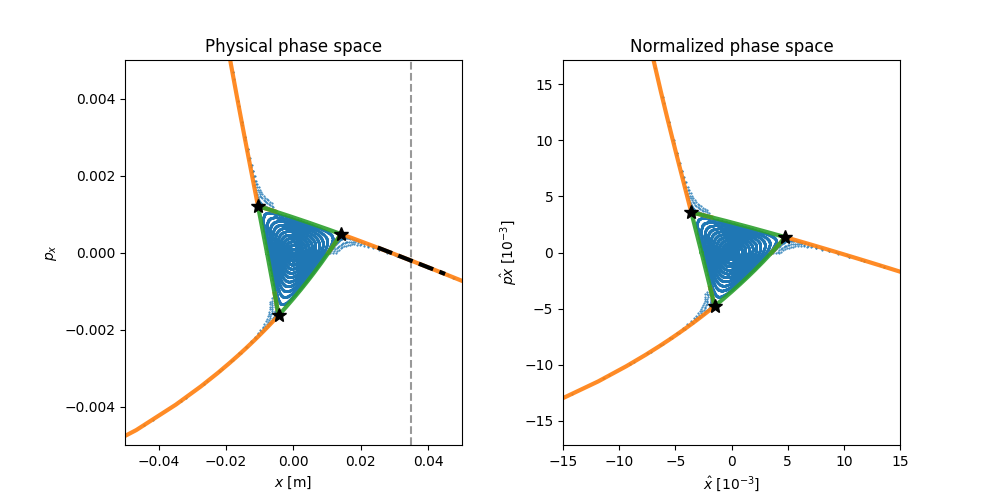

{'dpx_dx_at_septum': -0.03437452468219007,
 'stable_area': 6.512829794039671e-05,
 'x_fp': array([-0.01051056, -0.00441566,  0.01404017]),
 'px_fp': array([-0.01051056, -0.00441566,  0.01404017]),
 'x_norm_fp': array([-0.00357735, -0.00150288,  0.00477878]),
 'px_norm_fp': array([-0.00357735, -0.00150288,  0.00477878])}

In [6]:
from phase_space_characterization import characterize_phase_space_at_septum
characterize_phase_space_at_septum(line, plot=True)

In [7]:
# Time the chracterization function (with no plot)
%time res = characterize_phase_space_at_septum(line)

CPU times: user 369 ms, sys: 1.2 s, total: 1.57 s
Wall time: 224 ms


## Resonance optimization

In [8]:
# To use the results from our function in an optimization
# we need to wrap the function in an Action class

# Define action class
class ActionSeparatrix(xt.Action):
    
    def __init__(self, line):
        self.line = line
        
    def run(self):
        out = characterize_phase_space_at_septum(self.line)
        return out
    
# Build action object
action = ActionSeparatrix(line)

In [9]:
# Test the action
action.run()

{'dpx_dx_at_septum': -0.03437452468219007,
 'stable_area': 6.512829794039671e-05,
 'x_fp': array([-0.01051056, -0.00441566,  0.01404017]),
 'px_fp': array([-0.01051056, -0.00441566,  0.01404017]),
 'x_norm_fp': array([-0.00357735, -0.00150288,  0.00477878]),
 'px_norm_fp': array([-0.00357735, -0.00150288,  0.00477878])}

In [10]:
# From the action we can create optimization targets
# (we want to control the orientation of the saparatrix
#  and the size of the stable area) 
opt = line.match(
    solve=False,
    method='4d',
    vary=xt.VaryList(['kse1', 'kse2'], step=0.5, limits=[-7, 7]),
    targets=[
        action.target('stable_area', 1.e-4, tol=1e-5, weight=100), 
        action.target('dpx_dx_at_septum', 0.03, tol=5e-4)
    ]
)

In [11]:
# Inspect state before optimization
opt.target_status()

Target status:                          
id state tag tol_met      residue current_val target_val description                                 
 0 ON          False -3.48717e-05 6.51283e-05     0.0001 'stable_area', val=0.0001, tol=1e-05, we ...
 1 ON          False   -0.0643745  -0.0343745       0.03 'dpx_dx_at_septum', val=0.03, tol=0.0005 ...


### How to use an external python optimizer

We could get the solution simply calling `opt.solve()` which uses the Xsuite internal optimizer.

For some problems you might want to use a different optimizer (e.g. a derivative-free one) because it is more suited to your problem. For example here we show how to apply the [Py-BOBYQA optimizer](https://numericalalgorithmsgroup.github.io/pybobyqa/build/html/index.html) to our non-linear match problem.

In [13]:
# We extract a the merit function from our Xsuite optimizer objects
merit_function = opt.get_merit_function(
        return_scalar=True, # Py-BOBYQA wants a scalar merit function
        check_limits=False) # Py-BOBYQA wants to explore a bit outside the enforced limits

In [14]:
# Extract limits and starting point from merit function
bounds = merit_function.get_x_limits()
x0 = merit_function.get_x()

In [15]:
# Search optimum using Py-BOBYQA
import pybobyqa
soln = pybobyqa.solve(merit_function, x0=x0,
            bounds=bounds.T, # wants them transposed...
            rhobeg=5, rhoend=1e-4, maxfun=30,
            objfun_has_noise=True, # <-- helps in this case
            seek_global_minimum=True)
soln.x

array([4.94827514, 0.31019038])

In [16]:
# Set found solution in the line
merit_function.set_x(soln.x)

In [17]:
# Status after optimization
opt.target_status()
opt.vary_status()

Target status:                           
id state tag tol_met      residue current_val target_val description                                 
 0 ON           True -2.27281e-06 9.77272e-05     0.0001 'stable_area', val=0.0001, tol=1e-05, we ...
 1 ON           True  0.000316737   0.0303167       0.03 'dpx_dx_at_septum', val=0.03, tol=0.0005 ...
Vary status:                 
id state tag name lower_limit current_val upper_limit val_at_iter_0 step weight
 0 ON        kse1          -7     4.94828           7             1  0.5      1
 1 ON        kse2          -7     0.31019           7          -6.5  0.5      1


In [18]:
# Log solution in Xsuite optimizer log
opt.tag('bobyqa solution')
# Inspect the log
opt.log()

Table: 2 rows, 14 cols
iteration     penalty alpha tag             tol_met target_active hit_limits vary_active  vary_0 ...
        0   0.0644689    -1                 nn      yy            nn         yy                1
        1 0.000389845    -1 bobyqa solution yy      yy            nn         yy          4.94828

<IPython.core.display.Javascript object>


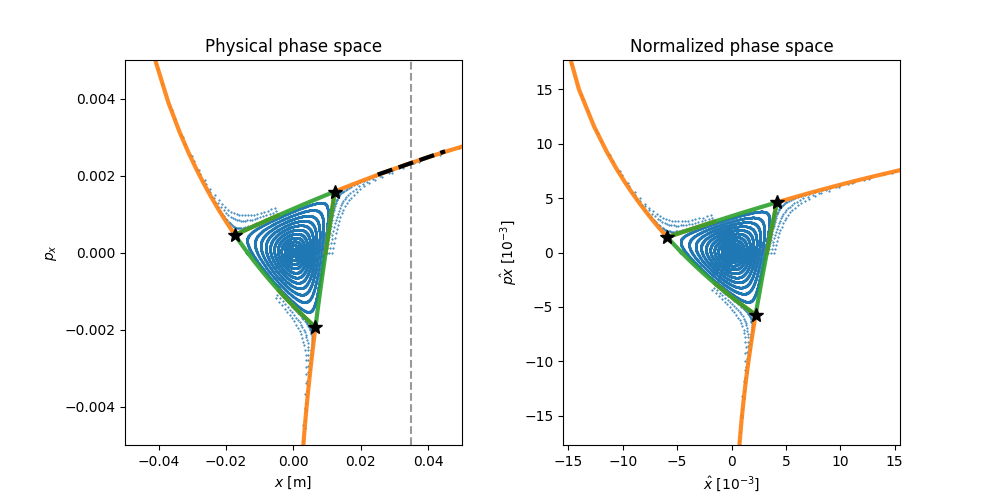

{'dpx_dx_at_septum': 0.03031673686506274,
 'stable_area': 9.772718870059357e-05,
 'x_fp': array([ 0.01226306, -0.0173478 ,  0.00650294]),
 'px_fp': array([ 0.01226306, -0.0173478 ,  0.00650294]),
 'x_norm_fp': array([ 0.00417393, -0.0059045 ,  0.0022134 ]),
 'px_norm_fp': array([ 0.00417393, -0.0059045 ,  0.0022134 ])}

In [19]:
# Visualize phase space after optimization
characterize_phase_space_at_septum(line, plot=True)

## Reload points from the optimization log

In [20]:
opt.log()

Table: 2 rows, 14 cols
iteration     penalty alpha tag             tol_met target_active hit_limits vary_active  vary_0 ...
        0   0.0644689    -1                 nn      yy            nn         yy                1
        1 0.000389845    -1 bobyqa solution yy      yy            nn         yy          4.94828

In [21]:
# Reload initial point
opt.reload(0)

In [22]:
opt.vary_status()

Vary status:                 
id state tag name lower_limit current_val upper_limit val_at_iter_0 step weight
 0 ON        kse1          -7           1           7             1  0.5      1
 1 ON        kse2          -7        -6.5           7          -6.5  0.5      1


<IPython.core.display.Javascript object>


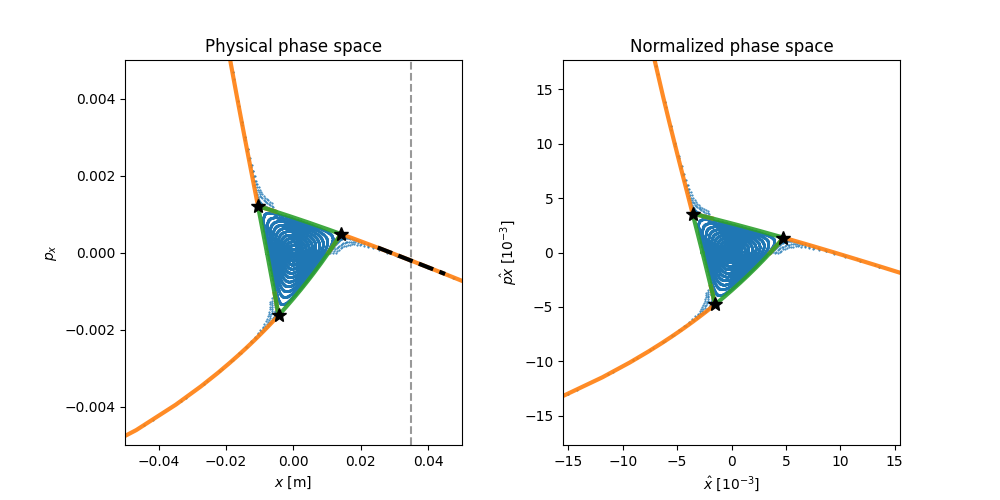

{'dpx_dx_at_septum': -0.03437452468219007,
 'stable_area': 6.512829794039671e-05,
 'x_fp': array([-0.01051056, -0.00441566,  0.01404017]),
 'px_fp': array([-0.01051056, -0.00441566,  0.01404017]),
 'x_norm_fp': array([-0.00357735, -0.00150288,  0.00477878]),
 'px_norm_fp': array([-0.00357735, -0.00150288,  0.00477878])}

In [23]:
characterize_phase_space_at_septum(line, plot=True)

In [24]:
# Reload tagged point
opt.reload(tag='bobyqa solution')

<IPython.core.display.Javascript object>


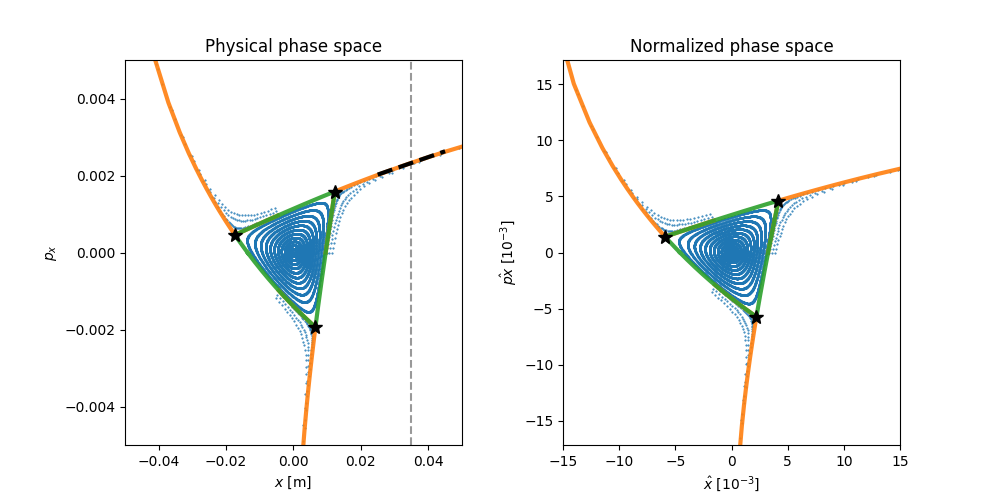

{'dpx_dx_at_septum': 0.03031673686506274,
 'stable_area': 9.772718870059357e-05,
 'x_fp': array([ 0.01226306, -0.0173478 ,  0.00650294]),
 'px_fp': array([ 0.01226306, -0.0173478 ,  0.00650294]),
 'x_norm_fp': array([ 0.00417393, -0.0059045 ,  0.0022134 ]),
 'px_norm_fp': array([ 0.00417393, -0.0059045 ,  0.0022134 ])}

In [25]:
characterize_phase_space_at_septum(line, plot=True)

### Save line with tuned extraction

In [26]:
line.to_json('pimms_02_tuned.json')